In [1]:
%load_ext autoreload
%autoreload 2
import tifffile as tiff
import numpy as np
import sys
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
import bm3d,bm4d
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
from src import *

# Denoising with Block-Matching algorithms

ℹ️ This notebook requires the samples of OABF dataset in the `dataset/sample/motion_corrected` folder generated with [1.1.1-Visualize_OABF_Dataset](../1-eda/1.1.1-Visualize_OABF_Dataset.ipynb).

BM3D and BM4D were the State-of-the-art in image denoising back in 2010. How do they perform when compared to DeepCAD?

In [2]:
dataset = Path("../dataset/dati_per_erzelli/mini2p_astro/good_example/2024Feb06-007")
sample_dir = Path("../dataset/sample")
raw_file = dataset / "raw_data/tSer_00001.tif"
motion_corrected_file = dataset / "motion_corrected/M2P_astro_OF_001_concatenate_corrected_aligned.tiff"
motion_corrected_sample_file = sample_dir / "motion_corrected" / "oabf_good_example.tiff"
deepcad_file = dataset / "denoised/M2P_astro_OF_001_concatenate_corrected_alignedf_E_05_Iter_6048_output.tif"
deepcad_sample_file = sample_dir / "deepcad" / "oabf_good_example.tiff"

The values must be ranged 0-1 because `sigma_psd` depends on it.

In [3]:
# 6s
motion_corrected_tiff = tiff.imread(motion_corrected_sample_file).astype(np.float32)
motion_corrected = motion_corrected_tiff / np.max(motion_corrected_tiff)
deepcad_tiff = tiff.imread(deepcad_sample_file).astype(np.float32)
deepcad = deepcad_tiff / np.max(deepcad_tiff)

## BM3D denoising

### 1. Running BM3D

In [4]:
# 3.4s/frame
bm3D_all = []
for i in tqdm(range(2)):
    bm3D_all.append(bm3d.bm3d(motion_corrected[0], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES))
bm3D_all=np.stack(bm3D_all)

100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


In [ ]:
tiff.imwrite(sample_dir / "bm3d/oabf_good_example.tiff", bm3D_all * np.max(motion_corrected_tiff), dtype=np.float64)

### 2. Computing evaluation metrics

In [ ]:
psnr=peak_signal_noise_ratio((deepcad*255).astype(np.uint), bm3D_all, data_range=255)
ssim=structural_similarity((deepcad*255).astype(np.uint), bm3D_all, data_range=255)
cprint('PSNR','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM3D_AllStages) --> 20.13dB
SSIM (DeepCAD - BM3D_AllStages) --> 0.572


Using HardThresholding-only stage, the results get slighly worse.

In [ ]:
psnr=peak_signal_noise_ratio((deepcad*255).astype(np.uint), bm3D_hard, data_range=255)
ssim=structural_similarity((deepcad*255).astype(np.uint), bm3D_hard, data_range=255)
cprint('PSNR','red:(DeepCAD - BM3D_HardThresholding)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM3D_HardThresholding)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM3D_HardThresholding) --> 19.75dB
SSIM (DeepCAD - BM3D_HardThresholding) --> 0.594


### 3. Visually comparing results

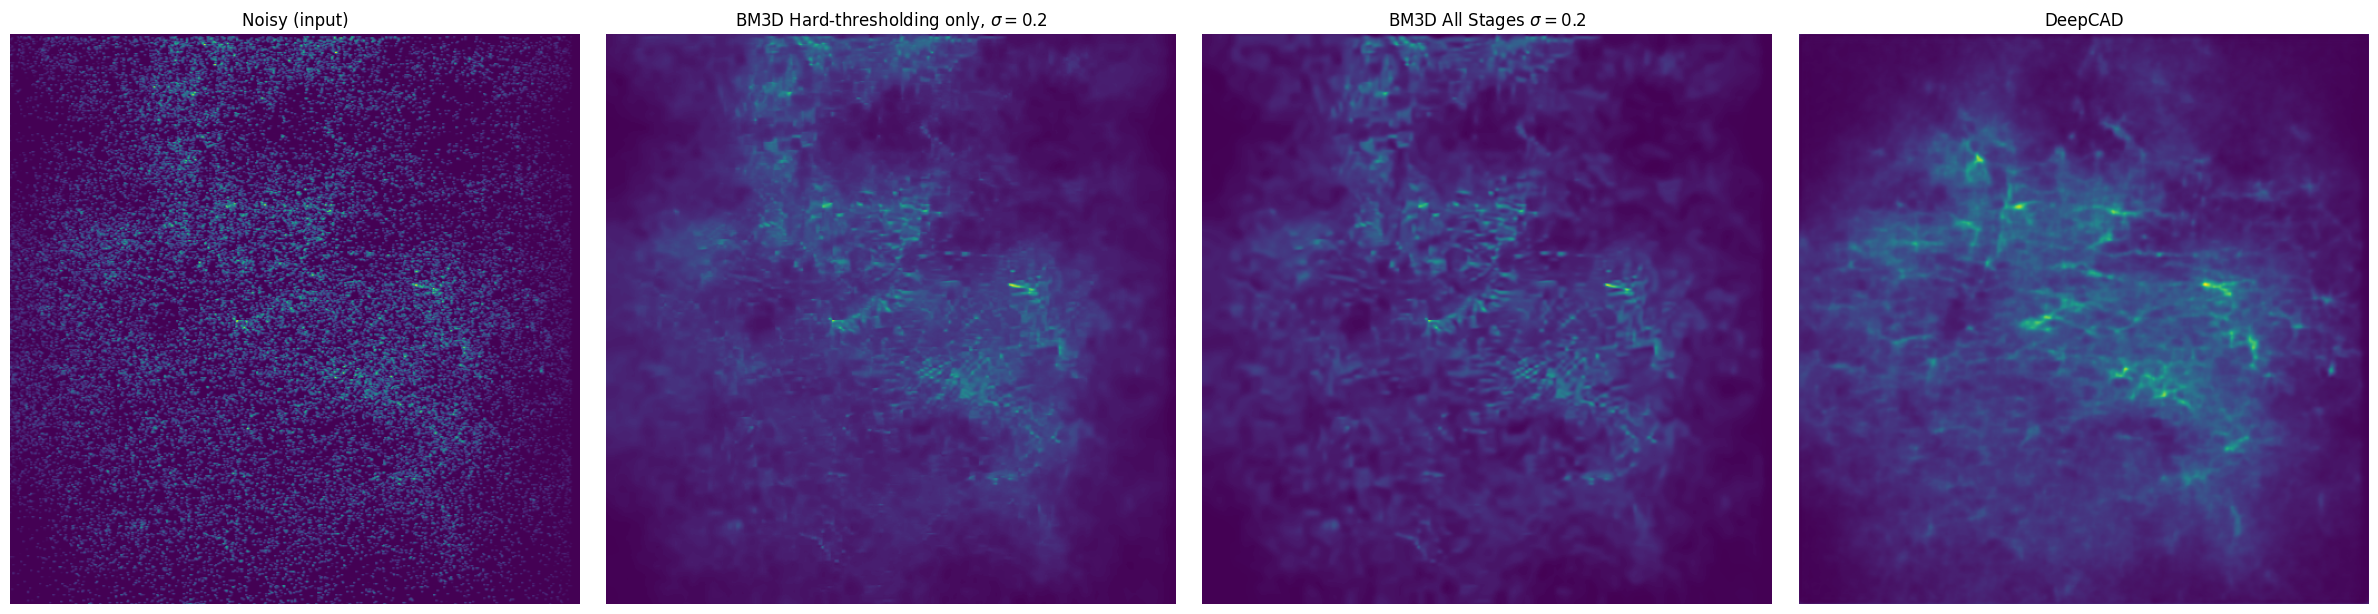

In [ ]:
imshow(
    {
        "Noisy (input)": motion_corrected[0],
        "BM3D All Stages $\sigma=0.2$": bm3D_all[0],
        "DeepCAD": deepcad[0],
    },
    size=6,
    cmap="grey"
)

BM3D is meant to be used with natural images. It does not perform well with neuroscience images. But BM4D will perform much better because we have a video with independent noise at pixel and frame level.

## BM4D

In [6]:
# 7.5s/frame (scales O(n) with the number of frames)
bm4D_all = bm4d.bm4d(motion_corrected[:10], sigma_psd=0.2, stage_arg=bm4d.BM4DStages.ALL_STAGES)
tiff.imwrite(sample_dir / "bm4d/oabf_good_example.tiff", bm4D_all * np.max(motion_corrected_tiff), dtype=np.float64)

In [57]:
psnr=peak_signal_noise_ratio(deepcad[:10], bm4D_all, data_range=1)
ssim=structural_similarity(deepcad[:10], bm4D_all, data_range=1)
cprint('PSNR','red:(DeepCAD - BM4D_All)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM4D_All)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM4D_All) --> 27.54dB
SSIM (DeepCAD - BM4D_All) --> 0.687


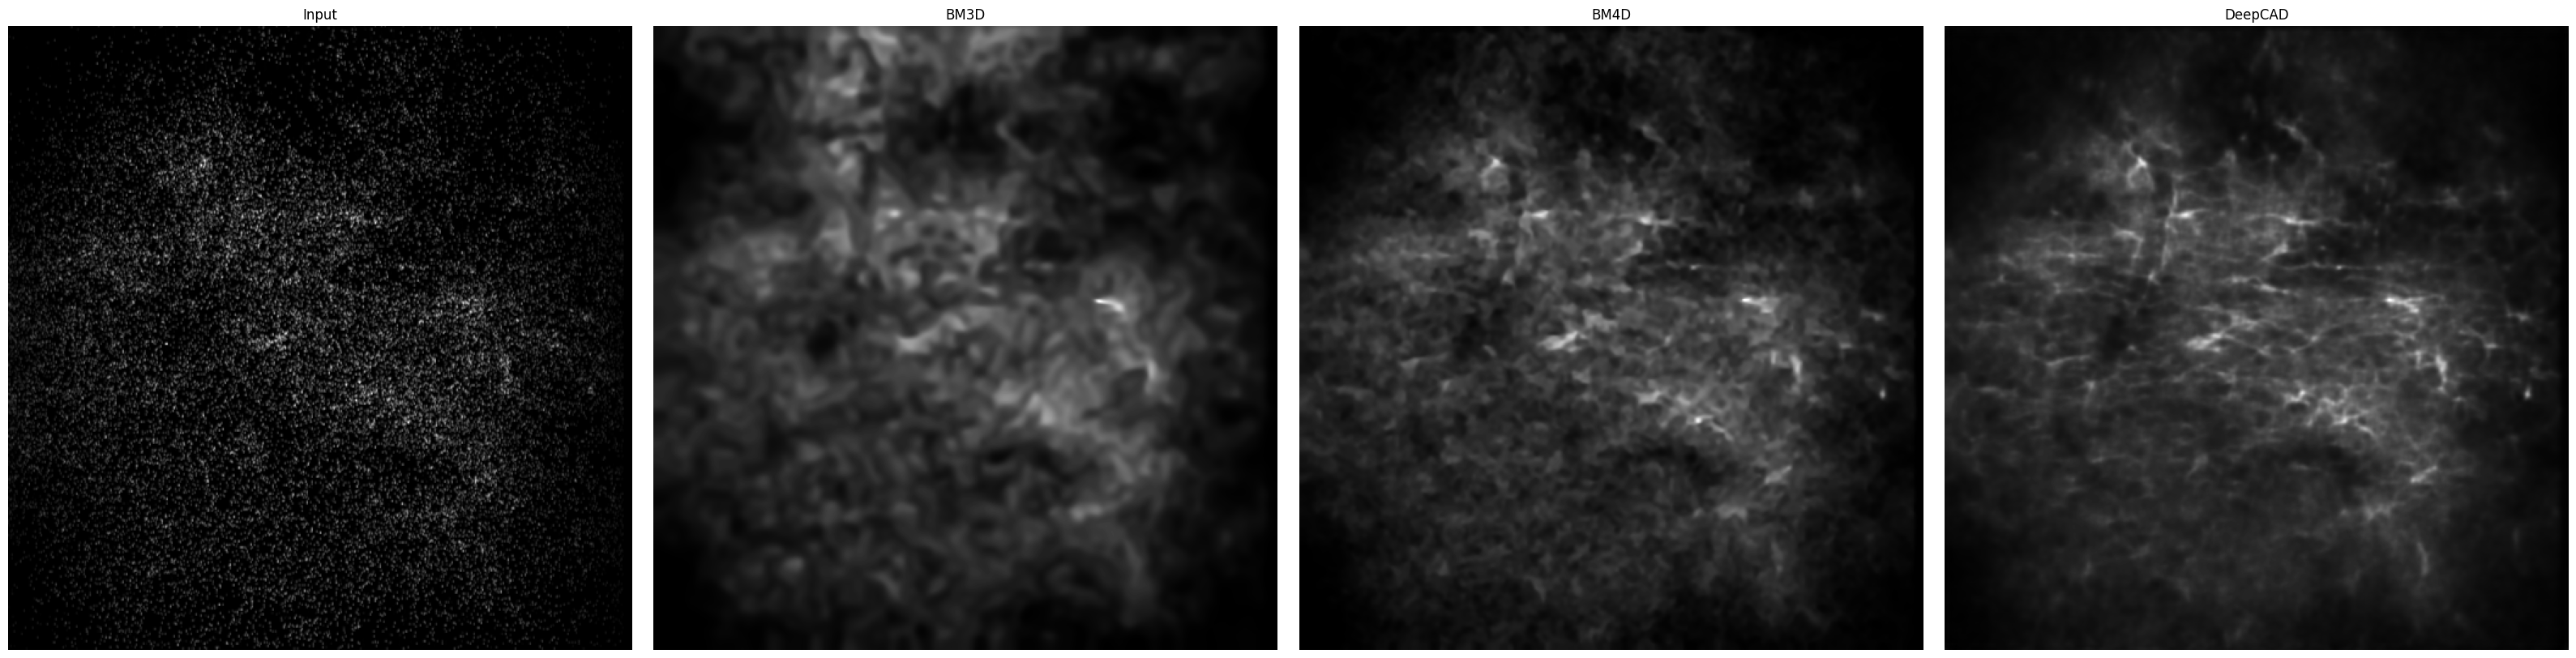

In [10]:
imshow({'Input':motion_corrected[1],'BM3D':bm3D_all[1],'BM4D':bm4D_all[1],'DeepCAD':deepcad[1]},size=8,cmap='grey')